In [1]:
import sys
import os
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gp

# NOTE: I am ignoring some warnings from geopandas
import warnings
warnings.filterwarnings("ignore")

cwd = os.getcwd()
#par = os.path.join(cwd, os.pardir)
par = os.path.dirname(cwd)
sys.path.append(par)

import sparse_nmf
import diffusion_nmf
import matrix_operation
import nmf_clustering
import importlib
importlib.reload(sparse_nmf)
importlib.reload(diffusion_nmf)
from sparse_nmf import SparseNMF
from diffusion_nmf import DiffusionNMF
from matrix_operation import mat_opr
from nmf_clustering import nmf_cluster

### Import Covid state level data

In [2]:
# Case counts
state_dset = pd.read_csv(os.path.join(par, 'collected_data/state_dataset.csv'), index_col = 0)
state_dset = mat_opr(state_dset)

In [3]:
# population data
population = pd.read_csv(os.path.join(par, 'collected_data/state_census_estimate.csv'), index_col = 'NAME')

In [4]:
# adjacency Laplacian
state_L = pd.read_csv(os.path.join(par, "collected_data/state_laplacian.csv"), index_col = 0).to_numpy()

In [5]:
# clean + normalize
state_iso = state_dset.known_iso()
pop_dict = {}
for col in state_iso.dataframe.columns:
    pop_dict[col] = population.loc[col,'POP']
    
state_norm = state_iso.population_normalizer(pop_dict)

In [6]:
state_dset.dataframe

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
2020-04-12,3667,272,3542,1280,22805,7307,12035,1625,1875,19895,...,730,5508,13780,2303,727,5274,10609,593,3341,270
2020-04-13,3870,277,3705,1410,23956,7691,13381,1758,1955,21019,...,868,5610,14328,2363,748,5747,10635,611,3428,275
2020-04-14,4041,285,3809,1498,25427,7950,13989,1926,2058,21628,...,988,5827,15088,2417,752,6182,10799,640,3555,282
2020-04-15,4307,293,3964,1569,26719,7956,14755,2014,2197,22511,...,1168,5827,16044,2548,759,6500,10942,702,3721,287
2020-04-16,4465,300,4237,1620,27687,8286,15884,2070,2350,23343,...,1311,6375,16985,2683,774,6889,11057,728,3875,296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-25,549934,71035,892236,347254,3814010,555971,349120,109636,49305,2365464,...,124496,866670,2992812,413317,24392,679762,449983,163804,677252,61951
2021-06-26,549934,71035,892711,347254,3814890,556542,349120,109657,49305,2365464,...,124496,866738,2994213,413668,24392,680060,450404,163804,677252,61951
2021-06-27,549934,71035,893147,347254,3815751,556775,349120,109682,49305,2365464,...,124496,866738,2994389,413950,24392,679828,450404,163804,677252,61951
2021-06-28,550451,71181,893560,348220,3817372,557004,349261,109700,49333,2365464,...,124515,866883,2995223,414204,24402,679917,450930,163967,677396,62099


#### Diffusion Kernel

In [7]:
beta = 1
I = np.identity(len(state_L))
K = np.linalg.inv(I + beta * state_L)

In [8]:
D = state_dset.dataframe.to_numpy()

### Diffusion NMF results

In [9]:
def state_map_basis(in_frame):
    # a function to make a plot of the US states colored by their factorization
    # takes an input data frame and returns a plot

    g_max = in_frame.max().max() 
    g_min = in_frame.min().min() 

    for rows in in_frame.index:
        labels = in_frame.loc[rows, :]
        fig = plt.figure(constrained_layout=True, figsize=(20,10))
        fig.suptitle(rows, size='x-large')
        grid = fig.add_gridspec(ncols = 3, nrows = 5)
        start = 0
        spacing = 1


        cluster_by_state = {}
        for c in labels.index:
            #s_name = state_dset.dataframe.iloc[:,c].name
            cluster_by_state[c] = labels[c]

        # json file with geographic info for each state -- required for geopandas
        state_map = gp.read_file("US_States_geojson.json")

        cluster_col = []
        for i in state_map["NAME"]:
            try:
                cluster_col.append(cluster_by_state[i])
            except:
                cluster_col.append(np.nan)

        state_map['cluster'] = cluster_col

        sx1 = fig.add_subplot(grid[start:(start + spacing * 3), 0:2]) #for most states

        sx2 = fig.add_subplot(grid[(start + spacing * 3):(start + spacing * 3 + spacing * 2), 0]) # alaska
        sx3 = fig.add_subplot(grid[(start + spacing * 3):(start + spacing * 3 + spacing * 2):, 1]) # Hawaii
        sx2.set_xlim(-200,-100)
        sx3.set_xlim(-165,-150)
        sx3.set_ylim(18,24)

        # specific color map
        cmapper = matplotlib.cm.get_cmap('inferno')
        cspace = np.linspace(0,0.99, 100)

        # plot using geopandas .plot()
        state_map[state_map['NAME'].isin(['Alaska','Hawaii', 'Puerto Rico']) == False].plot(column='cluster',
            ax=sx1, legend=True, vmax = g_max,vmin = g_min, figsize=(60,60), cmap='inferno')


        if 'Alaska' in in_frame.columns:
            al_val = state_map.loc[state_map['NAME'] == 'Alaska']['cluster']
            state_map[state_map['NAME'] == 'Alaska'].plot(column='cluster', ax=sx2, legend=False, figsize=(30,30), cmap = 'inferno', vmax = g_max, vmin = g_min)

        if 'Hawaii' in in_frame.columns:
            h_val = state_map.loc[state_map['NAME'] == 'Hawaii']['cluster']
            state_map[state_map['NAME']=='Hawaii'].plot(column='cluster', ax=sx3, legend=False, figsize=(30,30), cmap = 'inferno', vmax = g_max, vmin = g_min)

        if 'Puerto Rico' in in_frame.columns:
            p_val = state_map.loc[state_map['NAME'] == 'Puerto Rico']['cluster']
            sx4 = fig.add_subplot(grid[(start + spacing * 3):(start + spacing * 3 + spacing * 2):, 2]) # Puerto Rico
            sx4.set_xlim(-68,-64)
            state_map[state_map['NAME']=='Puerto Rico'].plot(column='cluster', ax=sx4, legend=False, figsize=(30,30), cmap = 'inferno', vmax = g_max, vmin = g_min)

In [10]:
differ = DiffusionNMF(D, K, ncomponents = 4, sparseV = 0.90, sparseX = None, iterations = 1000, tol = 1e-20)
differ.solver()
diffX = pd.DataFrame(differ.X, index = state_dset.dataframe.index)
diffV = pd.DataFrame(differ.V, columns = state_dset.dataframe.columns)

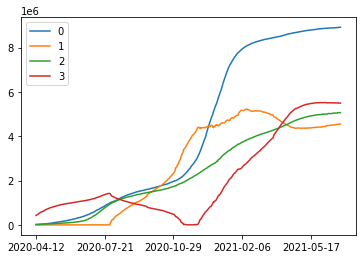

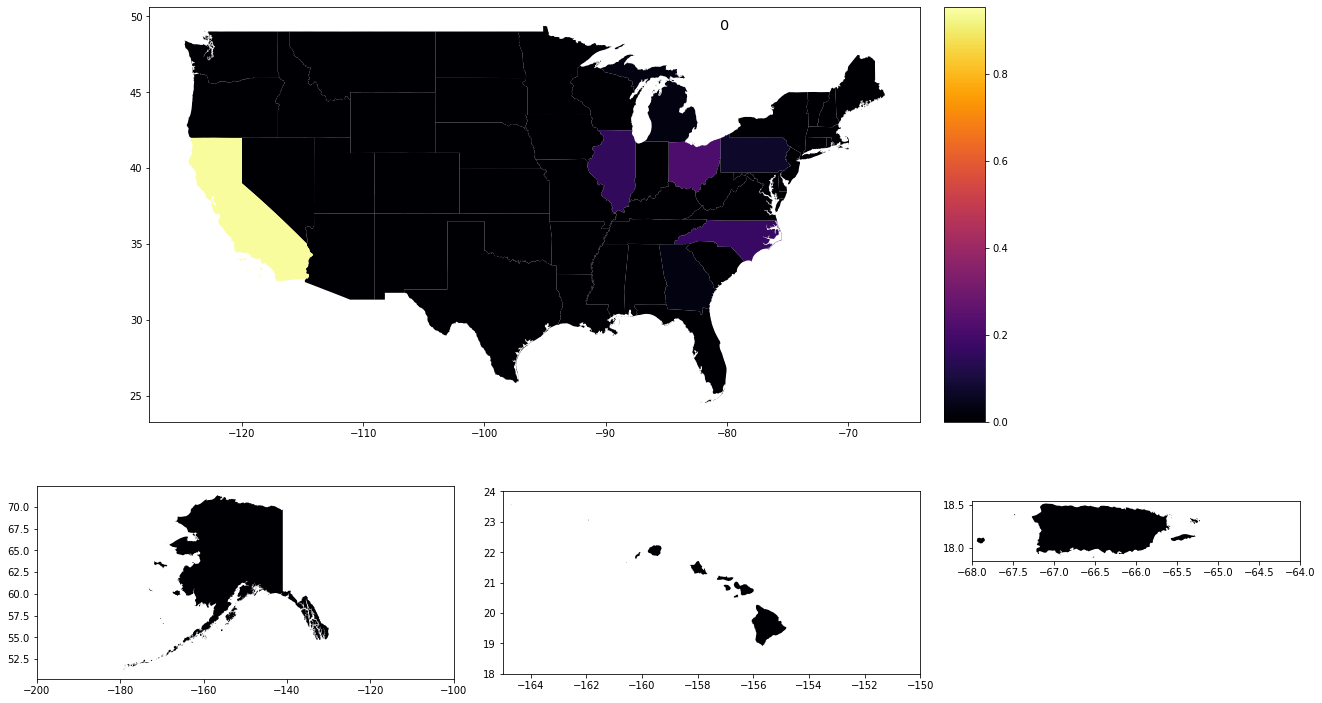

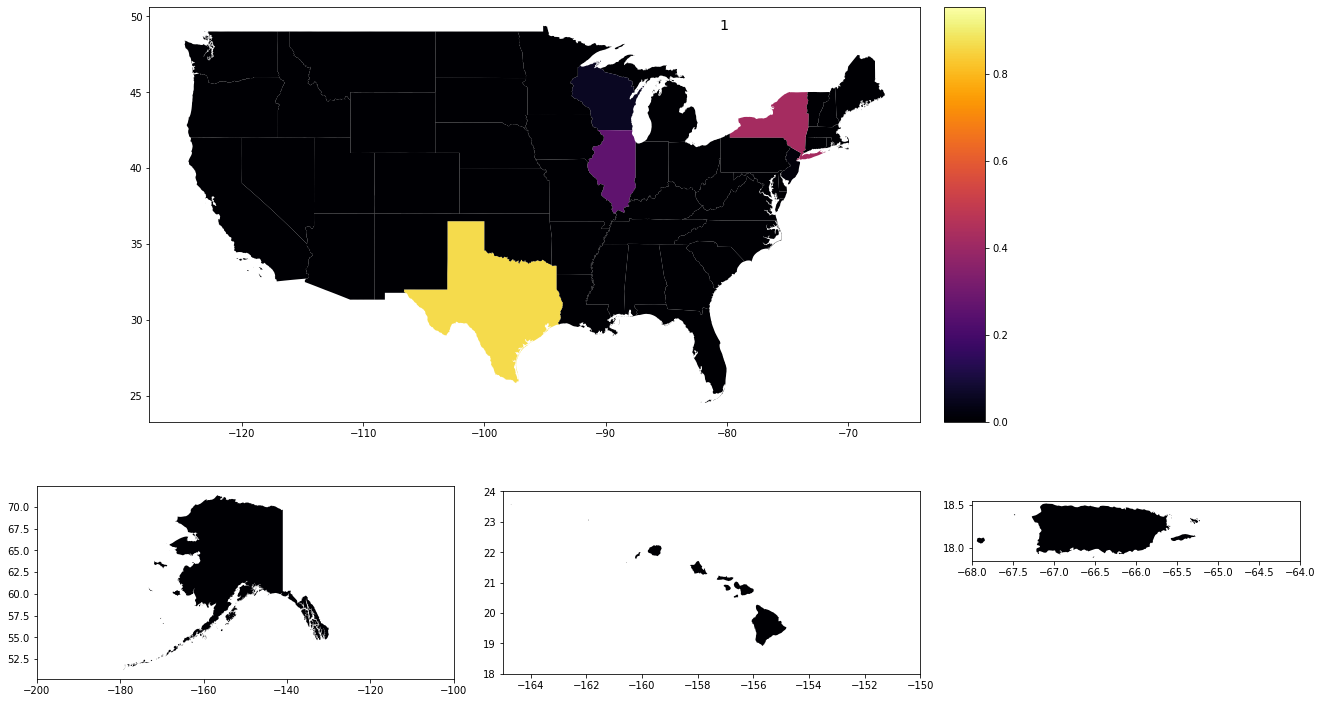

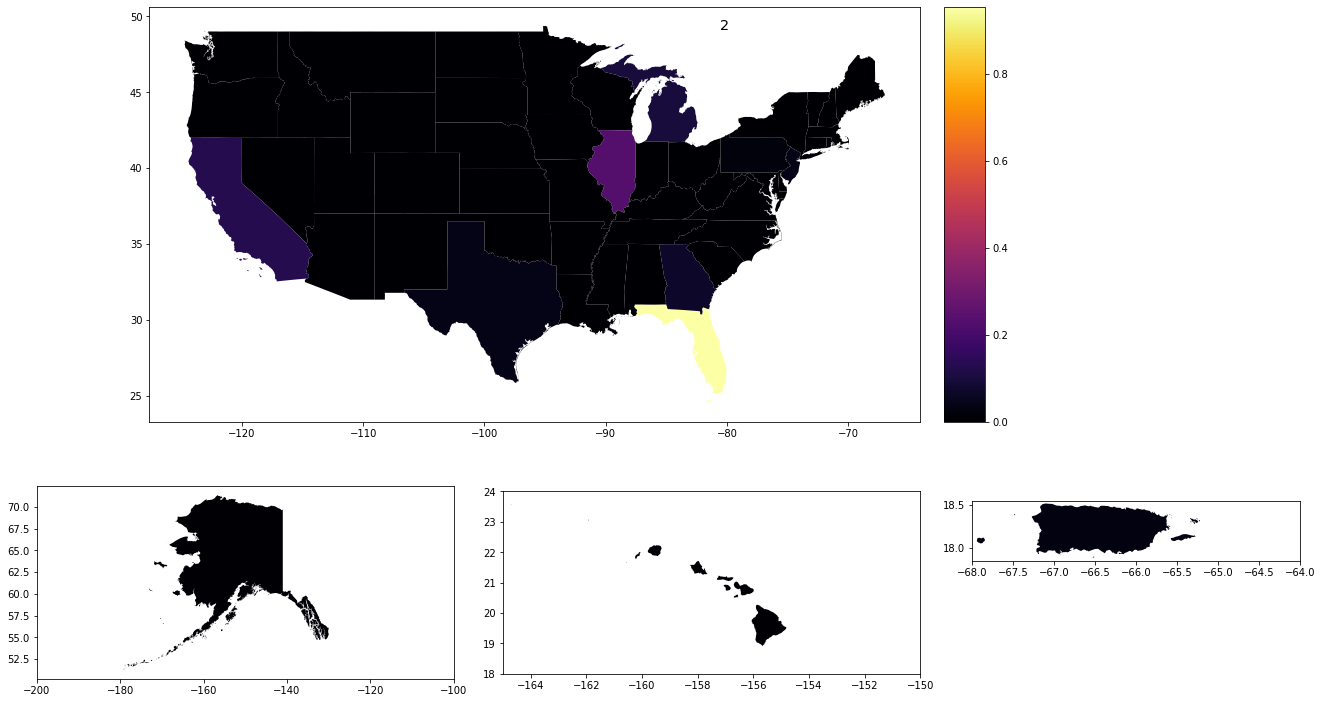

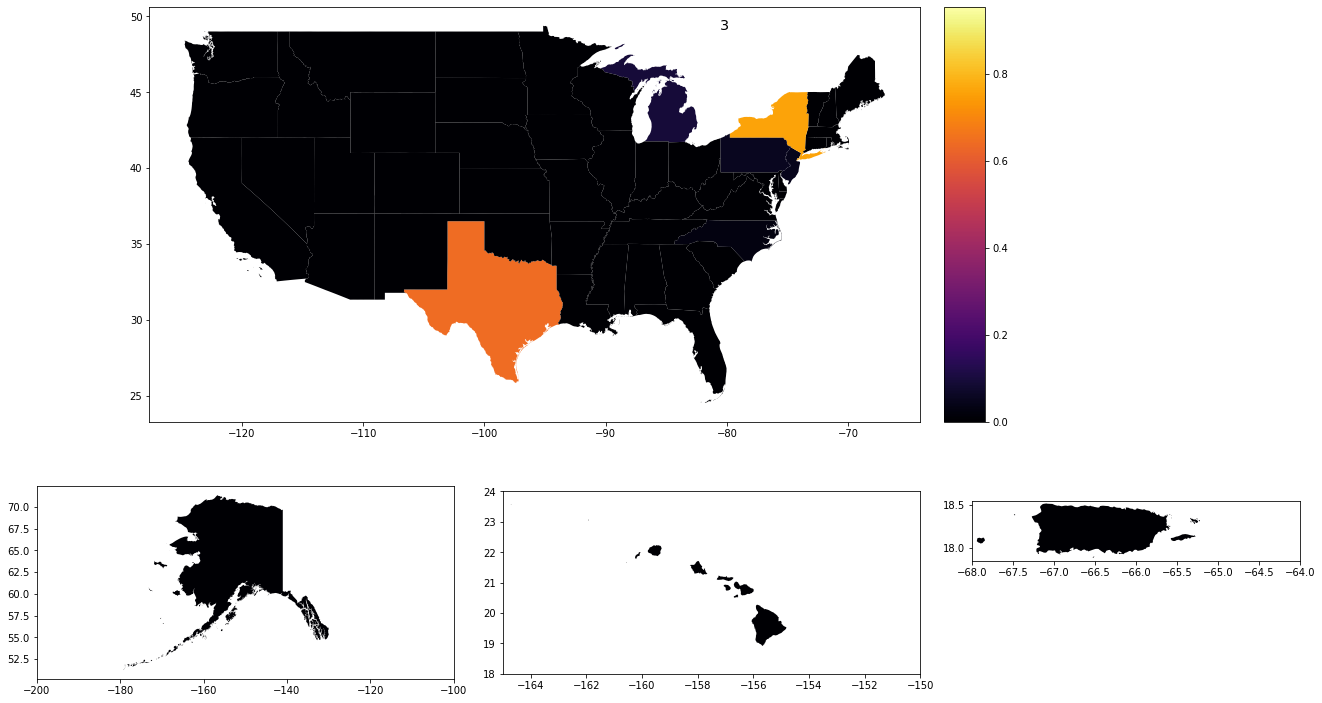

In [11]:
diffX.plot()
state_map_basis(diffV)